In [2]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [3]:
import torch
from torch.utils.data import DataLoader

import numpy as np
import tensorly as tl
import scipy.signal
import scipy.stats
import sklearn
import matplotlib.pyplot as plt
import copy

In [4]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
%load_ext autoreload
%autoreload 2

import tensor_regression as tr
import tensor_regression.util
from tensor_regression import standard_tensor_regression as STR

import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers
from basic_neural_processing_modules import h5_handling
from basic_neural_processing_modules import timeSeries
from basic_neural_processing_modules import similarity
from basic_neural_processing_modules import math_functions
from basic_neural_processing_modules import misc
from basic_neural_processing_modules import decomposition

In [5]:
%matplotlib notebook

In [8]:
dir_data = r'/media/rich/bigSSD/for_Josh/'
fileName_X_data = r'positions_convDR_meanSub_s2pInd.h5'
fileName_y_data = r'neural_data.h5'
positions = h5_handling.simple_load(directory=dir_data, fileName=fileName_X_data)
neural_data = h5_handling.simple_load(directory=dir_data, fileName=fileName_y_data)

In [9]:
torch_helpers.show_cuda_devices()
DEVICE = tr.util.set_device(use_GPU=True, verbose=True)

1 device(s) found.
0 GeForce RTX 3090
GPU is enabled.


In [10]:
pos_array = positions['positions_convDR_meanSub_s2pInd']
print(f'pos_array.shape = {pos_array.shape}')

pos_array.shape = (108000, 2744)


<IPython.core.display.Javascript object>


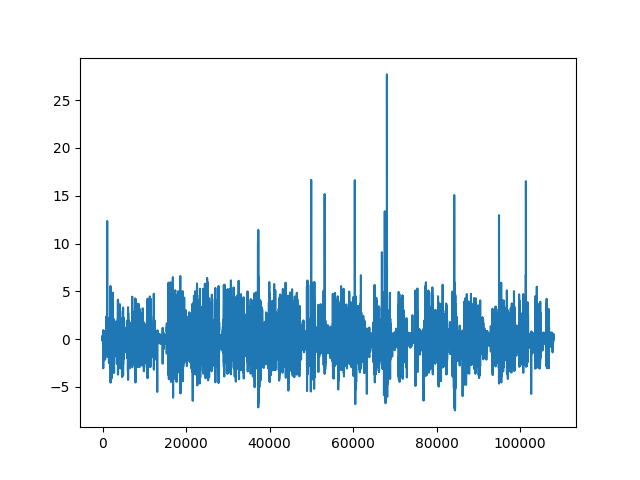

In [11]:
plt.figure()
plt.plot(pos_array[:,1200])

<IPython.core.display.Javascript object>


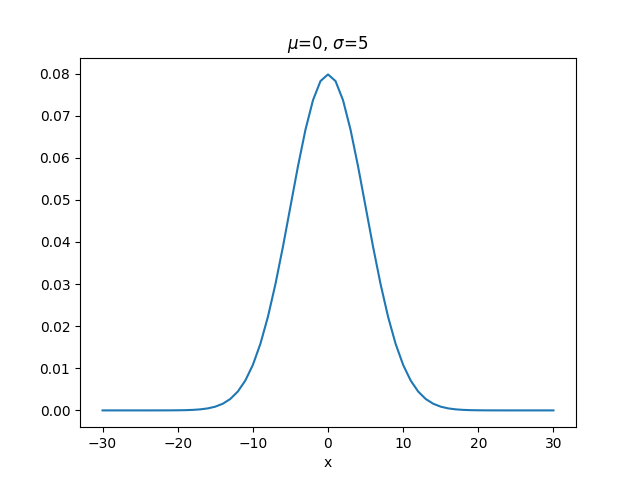

ThreadPool elapsed time : 0.27 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.43 seconds
neural_array.shape = (108000, 811)


In [12]:
ic = neural_data['is_cell']
good_ROIs = neural_data['good_ROIs']
spks = torch.tensor(neural_data['spks'][ic][good_ROIs]).T
dFoF = torch.tensor(neural_data['dFoF'][ic][good_ROIs]).T

gaussian_kernel , params_gaus = math_functions.gaussian(x=np.arange(-30,31,1),
                                                                  mu=0,
                                                                  sig=5,
                                                                  plot_pref=True)
spks_conv = timeSeries.convolve_along_axis(spks,
                                             gaussian_kernel,
                                             axis=0,
                                             mode='same',
                                             multicore_pref=True,
                                             verbose=True)

print(f'neural_array.shape = {spks_conv.shape}')

# win_range = [-120*3, -120*-1]
win_range = [-15, 15]

<IPython.core.display.Javascript object>


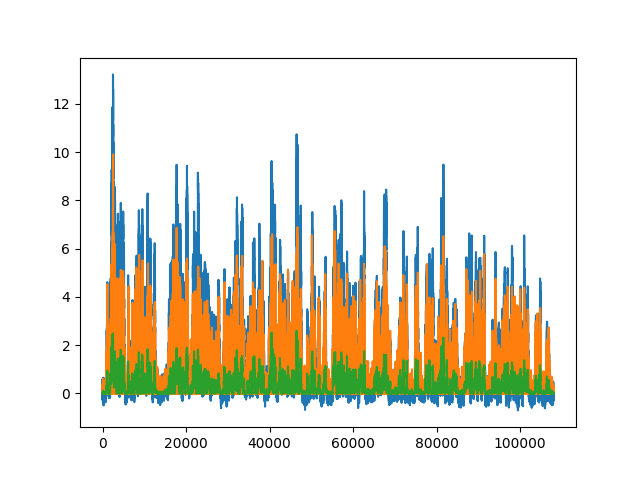

In [13]:
idx_toPlot = 35
plt.figure()
plt.plot(dFoF[:,idx_toPlot])
plt.plot(spks[:,idx_toPlot]/40)
plt.plot(spks_conv[:,idx_toPlot]/40)

In [14]:
pca_components , pca_scores , pca_EVR = decomposition.simple_pca(pos_array, mean_sub=True, zscore=True)

<IPython.core.display.Javascript object>


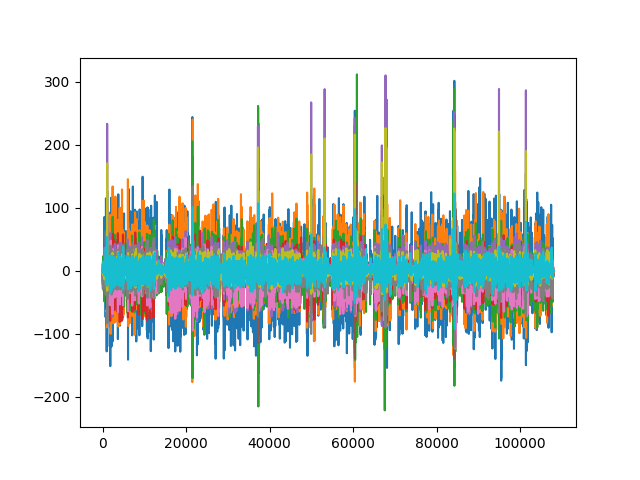

In [15]:
plt.figure()
plt.plot(pca_scores[:,:10]);

<IPython.core.display.Javascript object>


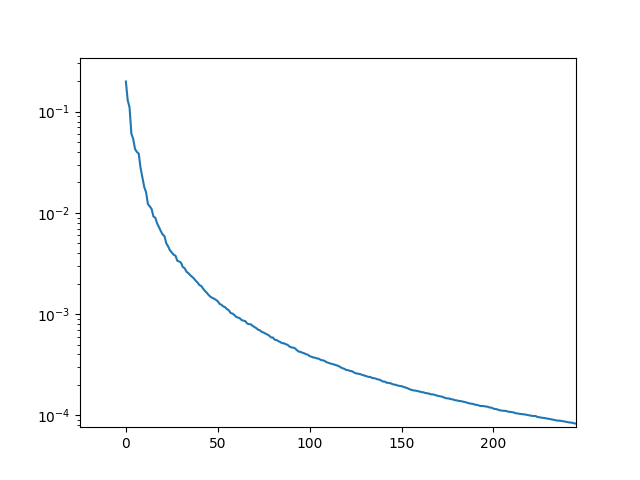

In [613]:
plt.figure()
plt.plot(EVR)
plt.yscale('log')

In [17]:
## convert X time series into a time series of time window slices

# input_array = pos_array - np.mean(pos_array, axis=0, keepdims=True)
# input_array = input_array[:,:600]

# input_array = pos_array - np.mean(scores, axis=1, keepdims=True)
input_array = pca_scores[:,:20]
# input_array = scipy.stats.zscore(scores[:,:200], axis=0)

win_len = int(2 * 30)
# win_len = 1
n_samples = input_array.shape[0]
slice_idx = np.arange(win_len//2, n_samples - win_len//2)
n_slices = len(slice_idx)
n_features = input_array.shape[1]

windowed_tensor = np.empty((n_slices, (win_len//2)*2, n_features), dtype=np.float32)
for ii, idx in enumerate(slice_idx):
#     ff_tensor[ii] = pos_array[idx:idx+win_len , :]
    windowed_tensor[ii] = input_array[idx-win_len//2:idx+win_len//2 , :]
print(f'X tensor shape:{windowed_tensor.shape}')
print(f'X tensor size on disk:{sys.getsizeof(windowed_tensor)/1000000000} GB')

# X = copy.deepcopy(ff_tensor)


X tensor shape:(107940, 60, 20)
X tensor size on disk:0.518112136 GB


In [18]:
X = torch.tensor(windowed_tensor[:,:,:], dtype=torch.float32)
# X = torch.tensor(windowed_tensor[:50000,:,:2744//3], dtype=torch.complex64)
y = torch.tensor(spks_conv[:,35], dtype=torch.float32)[slice_idx][:]
y = scipy.stats.zscore(y)
y = torch.roll(y, -20)

print(f'X size: {misc.estimate_size_of_float_array(input_shape=X.shape, bitsize=32)/1000000000} GB')
print(f'y size: {misc.estimate_size_of_float_array(input_shape=y.shape, bitsize=32)/1000000000} GB')

X size: 0.518112 GB
y size: 0.00043176 GB


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/scipy/stats/stats.py:2555: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  z[np.broadcast_to(isconst, z.shape)] = np.nan


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


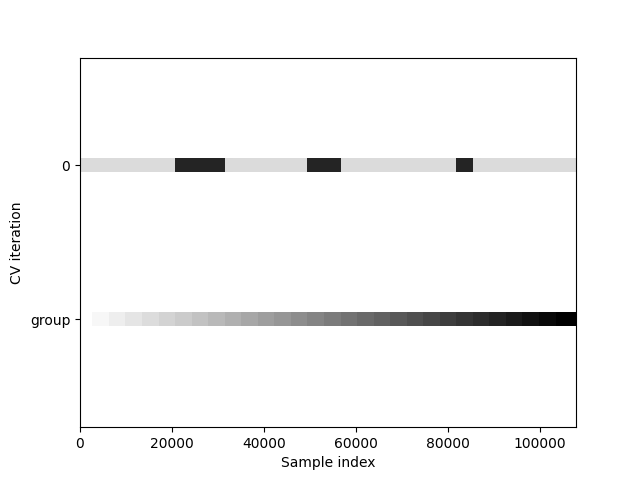

In [19]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import cross_validation

from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                 StratifiedKFold, GroupShuffleSplit,
                                 GroupKFold, StratifiedShuffleSplit)
Fs = 30
group_len = 60*2 * Fs # seconds * Fs
n_splits = 1
test_size = 0.2
groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx_all = cross_validation.make_cv_indices(cv,
                                        groups,
                                        lw=10,
                                        plot_pref=True)

In [36]:
import torch
from tqdm.notebook import tqdm, trange

DEVICE = tr.util.set_device(use_GPU=True)

# h_vals = np.logspace(-50, 2, num=30, endpoint=True, base=10.0)
# h_vals = np.int64(np.linspace(1, 300, num=30, endpoint=True))
# h_vals = np.logspace(-5.5, -3.5, num=20, endpoint=True)
# h_vals = np.array([1e-1, 5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2, 0.05e-2])
# h_vals = np.array([1e1, 5e0, 2e0, 1e0, 5e-1, 2e-1, 1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 0])
# h_vals = np.array([5e-1, 2e-1, 1e-1, 5e-2, 2e-2])
h_vals = np.array([.7])
# h_vals = np.array([0])


loss_all = []
params_all = []
EV_all = []
R_all = []
for ii, val in enumerate(h_vals):
    for cv_iter, cv_idx in tqdm(enumerate(cv_idx_all)):
        X_train = X[cv_idx[0]]
        y_train = y[cv_idx[0]]
        X_test = X[cv_idx[1]]
        y_test = y[cv_idx[1]]
        
        import gc
        if 'cpmlr' in globals():
            print('deleting cpmlr')
            del cpmlr
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()


        print(f'hyperparameter val: {val}')
        dataloader, dataset, sampler = tr.util.make_WindowedDataloader(X_train, y_train, win_range=win_range, batch_size=60000, drop_last=True)

        cpmlr = STR.CP_linear_regression(
#                                          dataloader.sample_shape,
                                         X_train.shape,
                                         rank=1,
                                         non_negative=[False, False],
                                         weights=None,
                                         Bcp_init=None,
                                             Bcp_init_scale=0.4,
#                                              Bcp_init_scale=0.005,
#                                          Bcp_init_scale=0.02,
                                         rank_complex=2,
                                         n_complex_dim=2,
                                         device=DEVICE,
                                         softplus_kwargs={
                                             'beta': 50,
                                             'threshold':1}
                                         )
        
        # tic = time.time()

        cpmlr.fit(X_train.to(DEVICE), y_train.to(DEVICE),
            lambda_L2=h_vals[ii], 
                    max_iter=200, 
                    tol=1e-50, 
                    patience=10,
                    verbose=1,
                    running_loss_logging_interval=1,
                    LBFGS_kwargs={
                        'lr' : 10, 
                        'max_iter' : 20, 
                        'max_eval' : None, 
                        'tolerance_grad' : 1e-07, 
                        'tolerance_change' : 1e-09, 
                        'history_size' : 100, 
                        'line_search_fn' : "strong_wolfe"
                    }
                 )

#         cpmlr.fit_Adam( X_train.to(DEVICE), y_train.to(DEVICE),
#                         lambda_L2=h_vals[ii], 
#                         max_iter=2000, 
#                         tol=1e-50, 
#                         patience=10,
#                         verbose=1,
# #                         running_loss_logging_interval=1,
#                     Adam_kwargs={
#                             'lr' : 0.01, 
#     #                             'betas' : (0.9, 0.999), 
#     #                             'eps' : 1e-08, 
#     #                             'weight_decay' : 0, 
#                             'amsgrad' : True
#                         }
#                     )

#         cpmlr.fit_batch_Adam(dataloader,
#                     lambda_L2=h_vals[ii], 
#                     max_iter=4000, 
#                     tol=1e-8, 
#                     patience=100,
#                     n_iter_inner=10,
#                     verbose=2,
#                     Adam_kwargs={
#                             'lr' : 0.0005, 
#     #                             'betas' : (0.9, 0.999), 
#     #                             'eps' : 1e-08, 
#     #                             'weight_decay' : 0, 
#                             'amsgrad' : True
#                         }
#              )
    
#         cpmlr.fit_batch_LBFGS(dataloader,
#                     lambda_L2=h_vals[ii], 
#                     max_iter=4000, 
#                     tol=1e-8, 
#                     patience=100,
#                     verbose=2,
#                     n_iter_inner=3,
#                     LBFGS_kwargs={
#                                     'lr' : 1, 
#                                     'max_iter' : 20, 
#                                     'max_eval' : None, 
#                                     'tolerance_grad' : 1e-07, 
#                                     'tolerance_change' : 1e-09, 
#                                     'history_size' : 100, 
#                                     'line_search_fn' : "strong_wolfe"
#                                 }
#              )

        # print(time.time() - tic)
        final_loss = cpmlr.loss_running[-1]
        print(f'loss: {final_loss}')

        loss_all.append(final_loss)
        params_all.append(cpmlr.get_params())

        y_pred = cpmlr.predict(X_train)
        EV_train = sklearn.metrics.explained_variance_score(y_train, y_pred)
        R_train = similarity.pairwise_similarity(y_train.numpy(), y_pred, method='pearson')
        y_pred = cpmlr.predict(X_test)
        EV_test = sklearn.metrics.explained_variance_score(y_test, y_pred)
        R_test = similarity.pairwise_similarity(y_test.numpy(), y_pred, method='pearson')
        print(f'EV_train / EV_test: {EV_train} / {EV_test}  ;  R_train / R_test: {R_train} / {R_test}')
        
        EV_all.append([EV_train, EV_test])
        R_all.append([R_train, R_test])

GPU is enabled.


0it [00:00, ?it/s]

deleting cpmlr
hyperparameter val: 0.7
[3, 1]
Convergence reached
loss: 0.736754310131073
EV_train / EV_test: 0.5385771989822388 / 0.4908987879753113  ;  R_train / R_test: [[0.74065435]] / [[0.7013242]]


<IPython.core.display.Javascript object>


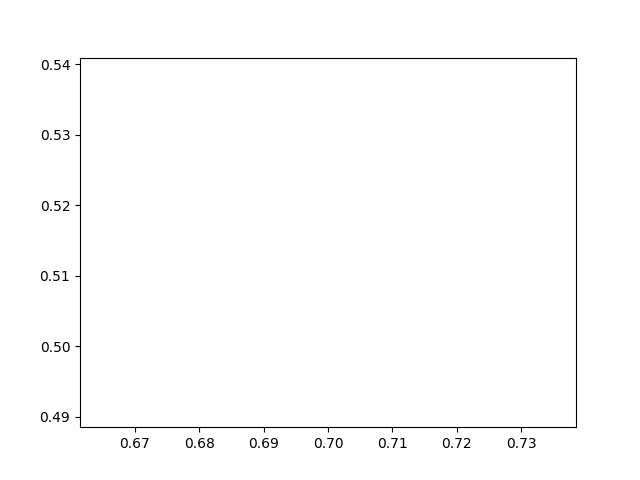

In [37]:
plt.figure()
plt.plot(h_vals, EV_all)

<IPython.core.display.Javascript object>


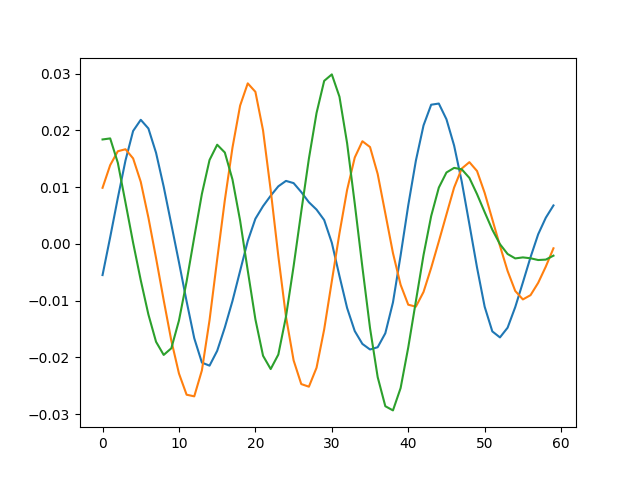

<IPython.core.display.Javascript object>


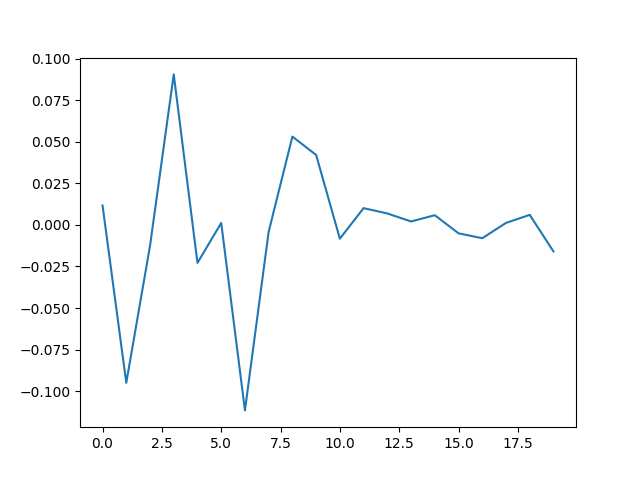

In [38]:
for ii in range(cpmlr.Bcp[0].shape[1]):
    plt.figure()
    plt.plot(cpmlr.Bcp[0][:,ii,:].cpu().detach().numpy())
plt.figure()
plt.plot(cpmlr.Bcp[1][:,:,0].cpu().detach().numpy())

<IPython.core.display.Javascript object>


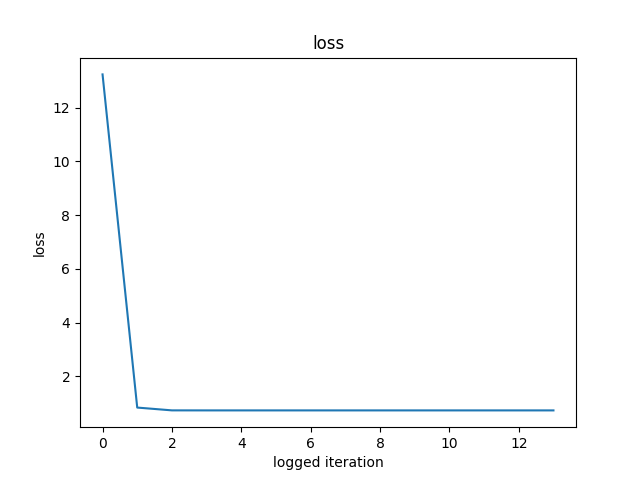

<IPython.core.display.Javascript object>


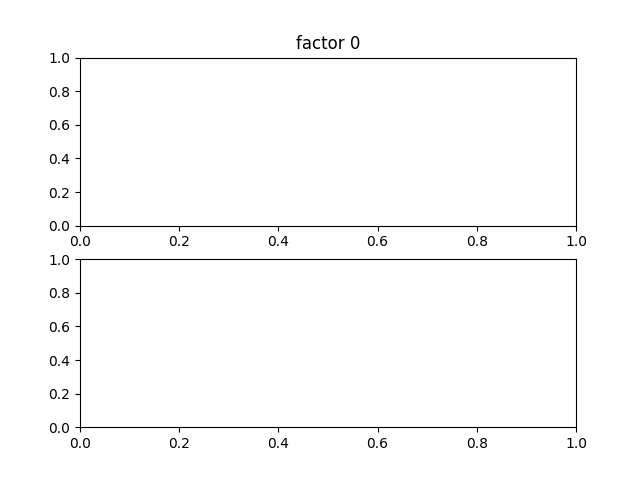

ValueError: x and y can be no greater than 2D, but have shapes (60,) and (60, 1, 3)

In [39]:
cpmlr.plot_outputs()

In [196]:
X_train = X[cv_idx[0]]
X_test = X[cv_idx[1]]


In [40]:
# test = np.array([ cpmlr.predict(dataset_test[ii][0][None,...]) for ii in range(100,20000)])
y_hat_test = cpmlr.predict(X_test.cpu())
y_hat_train = cpmlr.predict(X_train.cpu())

<IPython.core.display.Javascript object>


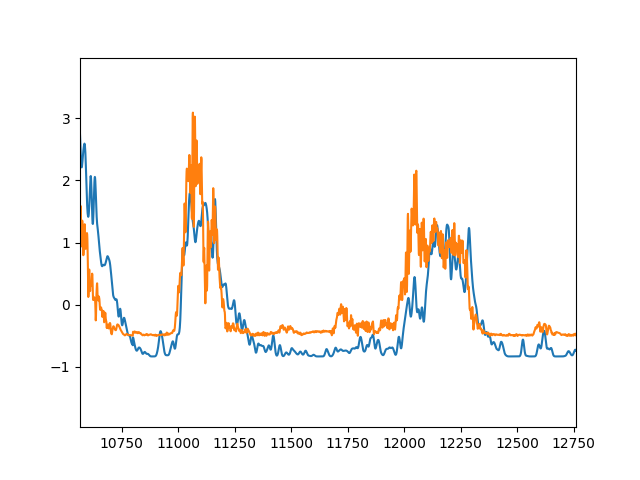

<IPython.core.display.Javascript object>


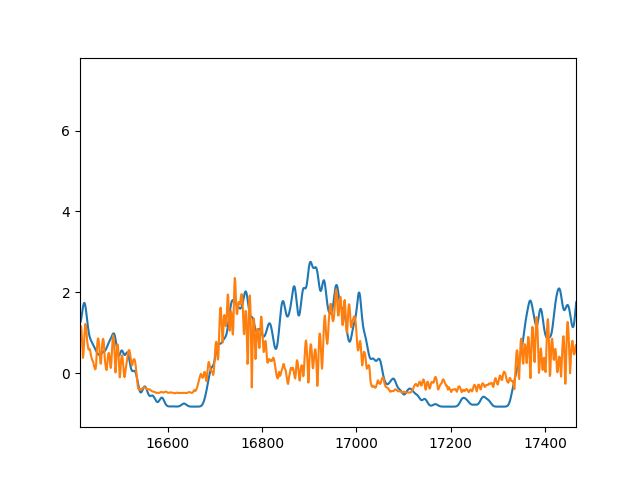

In [41]:
plt.figure()
plt.plot(y_test)
plt.plot(y_hat_test)

plt.figure()
plt.plot(y_train)
plt.plot(y_hat_train)

In [383]:
similarity.EV(y_train.numpy(), y_hat_train)

(0.2870115041732788, 0.2870115041732788, 0.2870115041732788)

In [384]:
import sklearn
sklearn.metrics.explained_variance_score(y_train.numpy(), y_hat_train)

0.2870117425918579

In [44]:
path_nwb = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/data/session.nwb'

from face_rhythm.util import helpers
helpers.dump_nwb(path_nwb)

import pynwb
from pynwb import NWBHDF5IO

with pynwb.NWBHDF5IO(path_nwb, mode='r') as io:
    file = io.read()
    pts_spaced_convDR = file.processing['Face Rhythm']['Optic Flow']['pts_spaced_convDR'].data[:]

CQT
     Sxx_allPixels:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_norm:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_normFactor:    (27288, 2)   ,  float32   ,   0.000218 GB
     Sxx_xAxis:    (436601,)   ,  float64   ,   0.003493 GB
     freq_idx_toUse:    (30,)   ,  bool   ,   0.0 GB
     freqs_Sxx_all:    (30,)   ,  float64   ,   0.0 GB
     freqs_Sxx_toUse:    (30,)   ,  float64   ,   0.0 GB
Optic Flow
     color_tuples:    (309285, 3)   ,  float64   ,   0.007423 GB
     displacements:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     pointInds_toUse:    (3102, 1, 2)   ,  float32   ,   2.5e-05 GB
     positions_cleanup:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_cleanup_absolute:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_convDR_absolute:    (1372, 2, 436601)   ,  float64   ,   9.584265 GB
     positions_convDR_meanSub:    (1372, 2, 436601)   ,  float64   ,   9.584

<IPython.core.display.Javascript object>


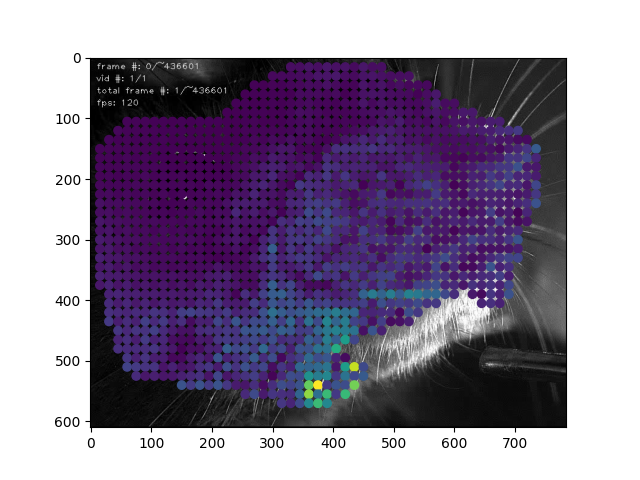

In [443]:
import imageio

# c_face_dots = cpmlr.Bcp[1].detach().cpu().numpy()
c_face_dots = test
c_face_dots = c_face_dots.reshape(c_face_dots.shape[0]//2, 2, c_face_dots.shape[1])
cfd_mag = np.linalg.norm(c_face_dots, axis=1)

path_mouse_movie = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/viz/just_mouse.avi'

reader = imageio.get_reader(path_mouse_movie)
for i, im in enumerate(reader):
    im_mouse = im
    break

for ii in range(cfd_mag.shape[1]):
    plt.figure()
    plt.imshow(im_mouse)
    plt.scatter(pts_spaced_convDR[:,0,0], pts_spaced_convDR[:,0,1], c=cfd_mag[:,ii])

In [ ]:
def unmix

In [200]:
pca_components.shape

(2744, 2744)

In [201]:
cpmlr.Bcp[1].shape

torch.Size([100, 8, 1])

In [45]:
mixing_vecs = torch.zeros(pca_components.shape[0], cpmlr.Bcp[1].shape[1])
mixing_vecs[:cpmlr.Bcp[1].shape[0],:] = cpmlr.Bcp[1][:,:,0].cpu().detach()

# test = pca_components.T @ mixing_vecs
test = torch.tensor(pca_components).T @ mixing_vecs
# test = torch.einsum('ab,bc->actorch.tensor(pca_components).T, mixing_vec[:,None]
test.shape

torch.Size([2744, 1])

<IPython.core.display.Javascript object>


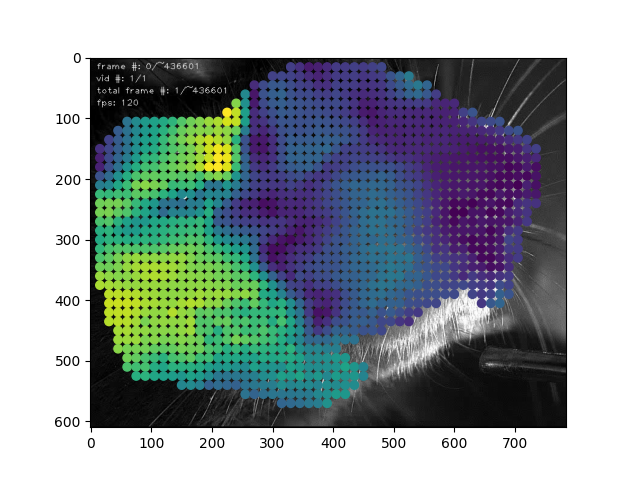

In [46]:
import imageio

# c_face_dots = cpmlr.Bcp[1].detach().cpu().numpy()
c_face_dots = test
c_face_dots = c_face_dots.reshape(c_face_dots.shape[0]//2, 2, c_face_dots.shape[1])
cfd_mag = np.linalg.norm(c_face_dots, axis=1)

path_mouse_movie = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/viz/just_mouse.avi'

reader = imageio.get_reader(path_mouse_movie)
for i, im in enumerate(reader):
    im_mouse = im
    break

for ii in range(cfd_mag.shape[1]):
    plt.figure()
    plt.imshow(im_mouse)
    plt.scatter(pts_spaced_convDR[:,0,0], pts_spaced_convDR[:,0,1], c=cfd_mag[:,ii])

In [586]:
full_array.shape

torch.Size([300, 2])

<IPython.core.display.Javascript object>


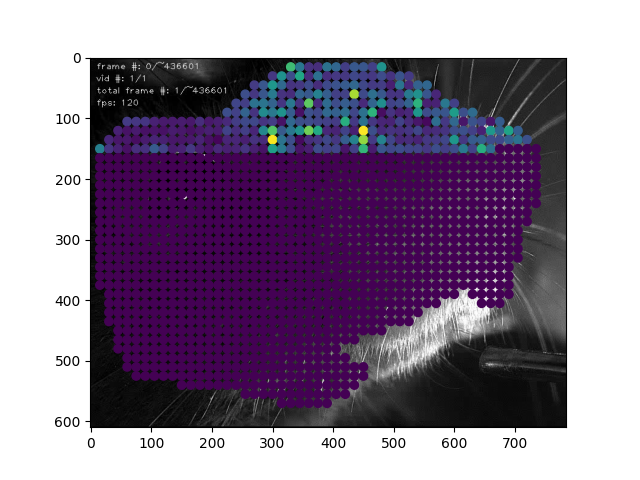

<IPython.core.display.Javascript object>


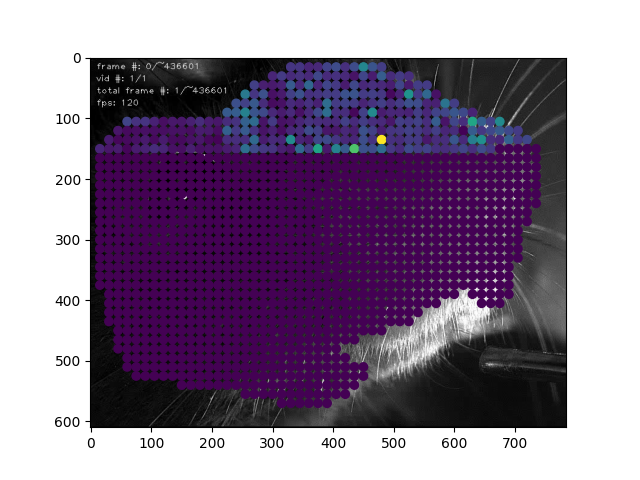

In [602]:
import imageio

full_array = torch.zeros(pos_array.shape[1], cpmlr.Bcp[1].shape[1])
full_array[:cpmlr.Bcp[1].shape[0],:] = cpmlr.Bcp[1][:,:,0].cpu().detach()

# c_face_dots = cpmlr.Bcp[1].detach().cpu().numpy()
c_face_dots = copy.deepcopy(full_array)
c_face_dots = c_face_dots.reshape(c_face_dots.shape[0]//2, 2, c_face_dots.shape[1])
cfd_mag = np.linalg.norm(c_face_dots, axis=1)

path_mouse_movie = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/viz/just_mouse.avi'

reader = imageio.get_reader(path_mouse_movie)
for i, im in enumerate(reader):
    im_mouse = im
    break

for ii in range(cfd_mag.shape[1]):
    plt.figure()
    plt.imshow(im_mouse)
    plt.scatter(pts_spaced_convDR[:,0,0], pts_spaced_convDR[:,0,1], c=cfd_mag[:,ii])